[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customize model
    - Adding layers
    - Adding dropout layer
- Adding data augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1787, done.
remote: Counting objects: 100% (1787/1787), done.
remote: Compressing objects: 100% (1759/1759), done.
remote: Total 1787 (delta 48), reused 1761 (delta 28), pack-reused 0
Receiving objects: 100% (1787/1787), 12.78 MiB | 25.87 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [155]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from torch.utils.data import ConcatDataset
import seaborn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [4]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [5]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [6]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

## **Create a custom dataset and a dataloader**

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import os

In [8]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [31]:
# Create dataframe
train_df = pd.DataFrame({"path": glob("data/train/*/*")})
val_df = pd.DataFrame({"path": glob("data/validation/*/*")})

# Create text column from path
train_df["text"] = train_df["path"].apply(lambda x: int(Path(x).parent.name))
val_df["text"] = val_df["path"].apply(lambda x: int(Path(x).parent.name))

# Shape of dataframe
print("Number of train images = {}, number of validation images = {},".format(train_df.shape, val_df.shape))

Number of train images = (1575, 2), number of validation images = (175, 2),


In [32]:
class ThaiDigitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = int(self.dataframe['text'][idx])
        image = Image.open(self.dataframe['path'][idx])
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [124]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=transform)
val_thaidigit_dataset = ThaiDigitDataset(val_df, transform=transform)

In [125]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Create the model**

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## **Train the model**

In [36]:
# Create training loop function
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [37]:
n_epoch = 50

net = ThaiDigitNet() # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
net, net_history = train(net, n_epoch, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.29900 train acc 0.12190 val loss 2.27554 val acc 0.18286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.26179 train acc 0.23175 val loss 2.23735 val acc 0.28571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.21460 train acc 0.29270 val loss 2.18480 val acc 0.34857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.15257 train acc 0.38349 val loss 2.11770 val acc 0.40000
--------------------------------------------------------------------------------
Epochs 5   train loss 2.07735 train acc 0.41079 val loss 2.03751 val acc 0.42857
--------------------------------------------------------------------------------
Epochs 6   train loss 1.98797 train acc 0.45016 val loss 1.94642 val acc 0.46857
----------------------------

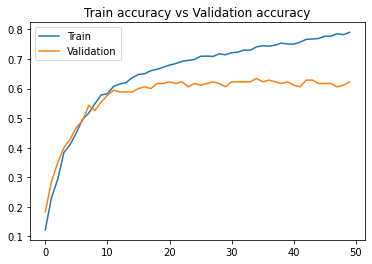

In [38]:
# Plot the training accuracy and validation accuracy
plt.plot(net_history["train_acc"], label="Train")
plt.plot(net_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

## **Save and load model**



In [39]:
save_path = "thai_digit.pth"
torch.save(net.state_dict(), save_path)  # save model parameters

In [40]:
model_path = "thai_digit.pth"
model = ThaiDigitNet()  # initialize the model
model.load_state_dict(torch.load(model_path))  # load the model weights

<All keys matched successfully>

## **Evaluate the model**

In [42]:
# Create evaluation function for the model
def evaluate(dataframe, model):
    model.eval()
    results = dataframe.copy()
    predictions = []
    for idx, row in results.iterrows():
        img = transform(Image.open(row.path))
        pred = model(1 - img)
        predictions.append(pred.argmax(1).item())

    results["prediction"] = predictions
    # Calculate accuracy
    accuracy = len(results[results.prediction == results.text]) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [43]:
evaluate(val_df, model)

Accuracy: 62.29%


,path,text,prediction
0,data/validation/8/44_9f2d7454-dd40-4c4a-916e-5...,8,4
1,data/validation/8/c17a09d4-a8b0-40be-bcd1-4666...,8,0
2,data/validation/8/504cd1fd-14d3-442a-b694-8da9...,8,8
3,data/validation/8/8e0e0499-7e9c-42cc-8b1c-8d54...,8,9
4,data/validation/8/ce169337-9ad4-423b-b185-eaf5...,8,0
...,...,...,...
170,data/validation/9/c2361c50-30ed-4420-b7b4-db0b...,9,4
171,data/validation/9/96140adf-5a81-4d06-841d-d6db...,9,1
172,data/validation/9/b6b40844-50cc-4847-8b83-9961...,9,9
173,data/validation/9/21_0cce64ca-f6e6-4b77-99ec-f...,9,9


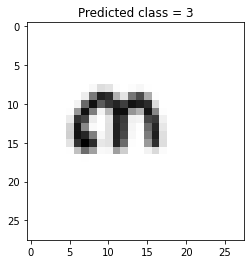

In [47]:
# Show some random images with their predicted number
random_number = random.randint(0, len(val_df))
img = Image.open(val_df.iloc[random_number].path)
img = transform(img)
transformed_img = 1 - img

pred = model(transformed_img).argmax(1)
plt.title(f"Predicted class = {pred.numpy()[0]}")
plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

## **Train neural netowrk model with more layers**

In [48]:
class ThaiDigitMoreLayers(nn.Module):
    def __init__(self):
        super(ThaiDigitMoreLayers, self).__init__()
        self.layers = nn.Sequential(
          
          nn.Linear(28*28, 392),
          nn.ReLU(),
          nn.Linear(392, 196),
          nn.ReLU(),
          nn.Linear(196, 98),
          nn.ReLU(),
          nn.Linear(98, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.layers(x)
  

In [49]:
n_epochs = 50

more_layers_model = ThaiDigitMoreLayers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(more_layers_model.parameters(), lr=0.01)

more_layers_model, more_layers_model_history = train(
    more_layers_model, n_epochs, loss_fn, optimizer, train_loader, val_loader
)


--------------------------------------------------------------------------------
Epochs 1   train loss 2.30289 train acc 0.10349 val loss 2.30183 val acc 0.06857
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30127 train acc 0.10349 val loss 2.30078 val acc 0.06857
--------------------------------------------------------------------------------
Epochs 3   train loss 2.29937 train acc 0.10349 val loss 2.29966 val acc 0.06857
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29750 train acc 0.10349 val loss 2.29844 val acc 0.06857
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29545 train acc 0.10349 val loss 2.29689 val acc 0.06857
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29316 train acc 0.10476 val loss 2.29525 val acc 0.06857
----------------------------

In [50]:
evaluate(val_df, more_layers_model)

Accuracy: 64.57%


,path,text,prediction
0,data/validation/8/44_9f2d7454-dd40-4c4a-916e-5...,8,8
1,data/validation/8/c17a09d4-a8b0-40be-bcd1-4666...,8,7
2,data/validation/8/504cd1fd-14d3-442a-b694-8da9...,8,8
3,data/validation/8/8e0e0499-7e9c-42cc-8b1c-8d54...,8,9
4,data/validation/8/ce169337-9ad4-423b-b185-eaf5...,8,8
...,...,...,...
170,data/validation/9/c2361c50-30ed-4420-b7b4-db0b...,9,8
171,data/validation/9/96140adf-5a81-4d06-841d-d6db...,9,9
172,data/validation/9/b6b40844-50cc-4847-8b83-9961...,9,9
173,data/validation/9/21_0cce64ca-f6e6-4b77-99ec-f...,9,9


## **Error analysis**

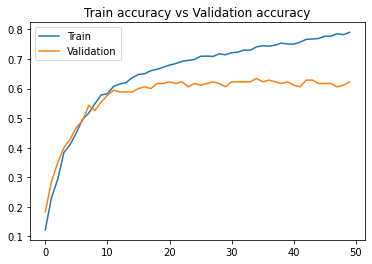

In [51]:
# Plot the training accuracy and validation accuracy
plt.plot(net_history["train_acc"], label="Train")
plt.plot(net_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

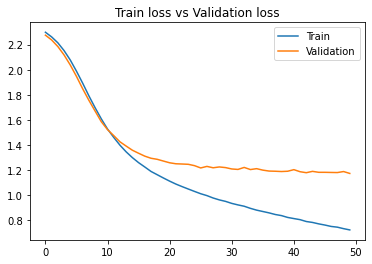

In [52]:
# Plot the training loss and validation loss
plt.plot(net_history["train_loss"], label="Train")
plt.plot(net_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()

The training accuracy of the model is higher than the validation accuracy.
This means that the model is overfitting the training data.
We can try to reduce the overfitting by adding regularization .

## **Regularization with Dropout**

Dropout is one of the techniques used to prevent overfitting

In [53]:
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [54]:
n_epochs = 50
drop_model = DropoutThaiDigit()  # Initialize a model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(drop_model.parameters(), lr=0.01)

drop_model, drop_model_history = train(drop_model, n_epochs, loss_fn, optimizer, train_loader, val_loader)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.28919 train acc 0.13079 val loss 2.27467 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25014 train acc 0.19492 val loss 2.24086 val acc 0.20571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.20461 train acc 0.24635 val loss 2.19470 val acc 0.25714
--------------------------------------------------------------------------------
Epochs 4   train loss 2.15059 train acc 0.31048 val loss 2.13339 val acc 0.32571
--------------------------------------------------------------------------------
Epochs 5   train loss 2.08323 train acc 0.35492 val loss 2.05854 val acc 0.42286
--------------------------------------------------------------------------------
Epochs 6   train loss 2.00653 train acc 0.40698 val loss 1.97237 val acc 0.46857
----------------------------

In [55]:
evaluate(val_df, drop_model)

Accuracy: 61.71%


,path,text,prediction
0,data/validation/8/44_9f2d7454-dd40-4c4a-916e-5...,8,8
1,data/validation/8/c17a09d4-a8b0-40be-bcd1-4666...,8,7
2,data/validation/8/504cd1fd-14d3-442a-b694-8da9...,8,8
3,data/validation/8/8e0e0499-7e9c-42cc-8b1c-8d54...,8,9
4,data/validation/8/ce169337-9ad4-423b-b185-eaf5...,8,8
...,...,...,...
170,data/validation/9/c2361c50-30ed-4420-b7b4-db0b...,9,4
171,data/validation/9/96140adf-5a81-4d06-841d-d6db...,9,1
172,data/validation/9/b6b40844-50cc-4847-8b83-9961...,9,9
173,data/validation/9/21_0cce64ca-f6e6-4b77-99ec-f...,9,9


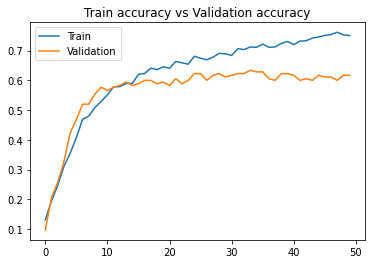

In [56]:
# Plot the training accuracy and validation accuracy
plt.plot(drop_model_history["train_acc"], label="Train")
plt.plot(drop_model_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

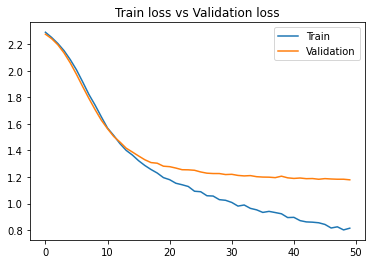

In [57]:
# Plot the training loss and validation loss
plt.plot(drop_model_history["train_loss"], label="Train")
plt.plot(drop_model_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()

Now the gap between the training accuracy and validation accuracy is smaller than before.

## **Image Augmentation**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [102]:
# augment_transform is same as transform but add RandomAffine to the image

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=(15, 30), translate=(0.05, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [107]:
example_augment_data = ThaiDigitDataset(train_df, transform=train_transform)
example_dataloader = DataLoader(example_augment_data, batch_size=16, shuffle=True)

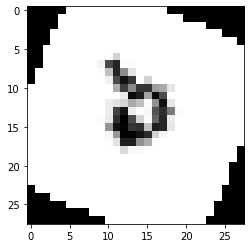

In [134]:
# Example of augmented image
img = (next(iter(example_dataloader))[0][1])
transformed_img = 1 - img

plt.imshow(transformed_img.squeeze(0), cmap="gray")
plt.show()

In [126]:
augmented_train_dataset = ThaiDigitDataset(train_df, transform=train_transform)
val_dataset = ThaiDigitDataset(val_df, transform=val_transform)

In [127]:
train_dataset = ConcatDataset([train_thaidigit_dataset, augmented_train_dataset])

In [128]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [135]:
# Let's train the model with augmented data
n_epochs = 50
augmented_model = DropoutThaiDigit()  # Initialize the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.28667 train acc 0.13460 val loss 2.24654 val acc 0.26286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.23130 train acc 0.21619 val loss 2.17375 val acc 0.31429
--------------------------------------------------------------------------------
Epochs 3   train loss 2.14558 train acc 0.29492 val loss 2.06870 val acc 0.39429
--------------------------------------------------------------------------------
Epochs 4   train loss 2.04261 train acc 0.35175 val loss 1.93413 val acc 0.41714
--------------------------------------------------------------------------------
Epochs 5   train loss 1.91392 train acc 0.40317 val loss 1.79244 val acc 0.44571
--------------------------------------------------------------------------------
Epochs 6   train loss 1.80532 train acc 0.42667 val loss 1.67800 val acc 0.46857
----------------------------

In [139]:
# Evaluate the new model with old dataset.
results = evaluate(val_df, augmented_model)

Accuracy: 62.86%


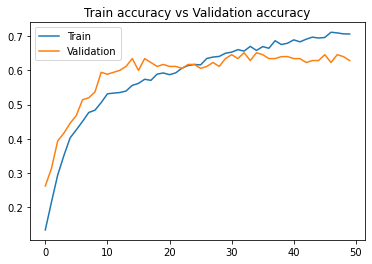

In [137]:
# Plot the training accuracy and validation accuracy
plt.plot(augmented_model_history["train_acc"], label="Train")
plt.plot(augmented_model_history["val_acc"], label="Validation")
plt.legend()
plt.title("Train accuracy vs Validation accuracy")
plt.show()

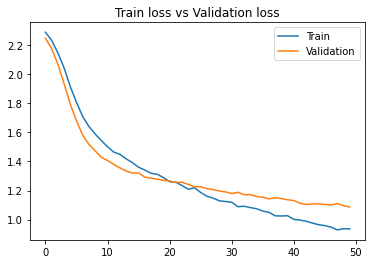

In [138]:
# Plot the training loss and validation loss
plt.plot(augmented_model_history["train_loss"], label="Train")
plt.plot(augmented_model_history["val_loss"], label="Validation")
plt.legend()
plt.title("Train loss vs Validation loss")
plt.show()

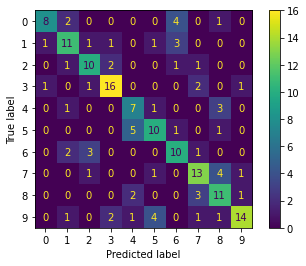

In [154]:
# Confusion matrix
cm = confusion_matrix(results.text, results.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()